# Read csv

In [2]:
import pandas as pd
import numpy as np
import sys
import os.path
import matplotlib.pyplot as plt

model = 'model'
tolerance = 'tolerance'
point_id = 'point_id'
time = 'time'
rewards = 'rewards'
result = 'result'

headers = [model, tolerance, point_id, time, rewards,result]
types = {
    model : str,
    tolerance : np.float64,
    point_id: np.int64,
    time : np.int64,
    rewards: str,
    result: np.float64
}

df = pd.read_csv('all.csv', header = 0, names = headers, low_memory = False, dtype = types)

In [3]:
p1 = 'p1'
p2 = 'p2'
p3 = 'p3'
p4 = 'p4'
p5 = 'p5'
p6 = 'p6'
p7 = 'p7'
p8 = 'p8'
p9 = 'p9'
p10 = 'p10'
p11 = 'p11'
p12 = 'p12'
p13 = 'p13'
avg = 'avg'

# Átlagos szórás az eredmények között
Adatfeldolgozás:
1. SPDN által visszaadott reward eredmények a _values_ oszlopban, ;-vel elválasztva
2. Ezeket külön oszlopokra bontjuk, a _pointid_ alapján eggyesítjük, oszlopok (vagyis reward eredmények) szórását vesszük
3. Külön _avg_ oszlopban átlagoljuk soronként a szórásokat
4. Az így kapott összes sorra átlagoljuk a szórás átlagokat :D

In [7]:
def getAvgVariances(newDf):
    # These must be done before getAvgVariances:
    #    smpl_df = df[df.model == 'SMPL']
    #    smpl_df[p1], smpl_df[p2] = df[values].str.split(';', 1).str
    for col in newDf.columns:
        newDf[col] = pd.to_numeric(newDf[col], errors = 'coerce')
    newDf = newDf.drop(columns=[model, tolerance, time, rewards])\
                    .groupby(point_id).var()\
                    .dropna(thresh=1)
    newDf[avg] = newDf[newDf.columns[0]]
    for col in newDf.columns[1:(len(newDf.columns)-1)]:
        newDf[avg] = newDf[avg] + newDf[col]
    newDf[avg] = newDf[avg] / (len(newDf.columns) - 1)
    return np.average(newDf.loc[:,avg].values)
    

In [11]:
avgs = {}

smpl_df = df[df.model == 'SMPL']
smpl_df[p1], smpl_df[p2] = df[rewards].str.split(';', 1).str
avgs['SMPL'] = getAvgVariances(smpl_df)

vcls_df = df[df.model == 'VCLS']
vcls_df[p1], vcls_df[p2], vcls_df[p3], vcls_df[p4],vcls_df[p5], vcls_df[p6],vcls_df[p7]  = df[rewards].str.split(';', 6).str
avgs['VCLS'] = getAvgVariances(vcls_df)

hybc_df = df[df.model == 'HYBC']
hybc_df[p1], hybc_df[p2], hybc_df[p3], hybc_df[p4]  = df[rewards].str.split(';', 3).str
avgs['HYBC'] = getAvgVariances(hybc_df)

fil3_df = df[df.model == 'FIL3']
fil3_df[p1], fil3_df[p2], fil3_df[p3], fil3_df[p4] = df[rewards].str.split(';', 3).str
avgs['FIL3'] = getAvgVariances(fil3_df)

fil4_df = df[df.model == 'FIL4']
fil4_df[p1], fil4_df[p2], fil4_df[p3], fil4_df[p4], fil4_df[p5] = df[rewards].str.split(';', 4).str
avgs['FIL4'] = getAvgVariances(fil4_df)

fil5_df = df[df.model == 'FIL5']
fil5_df[p1], fil5_df[p2], fil5_df[p3], fil5_df[p4], fil5_df[p5], fil5_df[p6] = df[rewards].str.split(';', 5).str
avgs['FIL5'] = getAvgVariances(fil5_df)

fil6_df = df[df.model == 'FIL6']
fil6_df[p1], fil6_df[p2], fil6_df[p3], fil6_df[p4], fil6_df[p5], fil6_df[p6], fil6_df[p7] = df[rewards].str.split(';', 6).str
avgs['FIL6'] = getAvgVariances(fil6_df)

fil7_df = df[df.model == 'FIL7']
fil7_df[p1], fil7_df[p2], fil7_df[p3], fil7_df[p4], fil7_df[p5], fil7_df[p6], fil7_df[p7], fil7_df[p8] = df[rewards].str.split(';', 7).str
avgs['FIL7'] = getAvgVariances(fil7_df)

fil8_df = df[df.model == 'FIL8']
fil8_df[p1], fil8_df[p2], fil8_df[p3], fil8_df[p4], fil8_df[p5], fil8_df[p6], fil8_df[p7], fil8_df[p8], fil8_df[p9] = df[rewards].str.split(';', 8).str
avgs['FIL8'] = getAvgVariances(fil8_df)

fil9_df = df[df.model == 'FIL9']
fil9_df[p1], fil9_df[p2], fil9_df[p3], fil9_df[p4], fil9_df[p5], fil9_df[p6], fil9_df[p7], fil9_df[p8], fil9_df[p9], fil9_df[p10] = df[rewards].str.split(';', 9).str
avgs['FIL9'] = getAvgVariances(fil9_df)

fil10_df = df[df.model == 'FIL10']
fil10_df[p1], fil10_df[p2], fil10_df[p3], fil10_df[p4], fil10_df[p5], fil10_df[p6], fil10_df[p7], fil10_df[p8], fil10_df[p9], fil10_df[p10], fil10_df[p11] = df[rewards].str.split(';', 10).str
avgs['FIL10'] = getAvgVariances(fil10_df)

fil11_df = df[df.model == 'FIL11']
fil11_df[p1], fil11_df[p2], fil11_df[p3], fil11_df[p4], fil11_df[p5], fil11_df[p6], fil11_df[p7], fil11_df[p8], fil11_df[p9], fil11_df[p10], fil11_df[p11], fil11_df[p12] = df[rewards].str.split(';', 11).str
avgs['FIL11'] = getAvgVariances(fil11_df)

fil12_df = df[df.model == 'FIL12']
fil12_df[p1], fil12_df[p2], fil12_df[p3], fil12_df[p4], fil12_df[p5], fil12_df[p6], fil12_df[p7], fil12_df[p8], fil12_df[p9], fil12_df[p10], fil12_df[p11], fil12_df[p12], fil12_df[p13] = df[rewards].str.split(';', 12).str
avgs['FIL12'] = getAvgVariances(fil12_df)

avgs

C:\Users\Timi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Timi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Timi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

{'SMPL': 0.0,
 'VCLS': 1735709412072526.8,
 'HYBC': nan,
 'FIL3': 0.0002777904588309557,
 'FIL4': 0.01329569366735577,
 'FIL5': 0.03006552245924825,
 'FIL6': 0.00560402640767798,
 'FIL7': 0.13387397185909053,
 'FIL8': 0.5396193088086996,
 'FIL9': 0.16083220896003414,
 'FIL10': 1.143915015181659,
 'FIL11': 0.6027308214206674,
 'FIL12': nan}

# Mean runtime with different tolerance

In [13]:
sum_times_df = df.loc[:,[model,tolerance,time]].groupby([model,tolerance]).mean().sort_values(by=[model, tolerance])

models = sum_times_df.index.levels[0].tolist()
tols = sum_times_df.index.levels[1].tolist()

sum_times_df = sum_times_df.reset_index()
for mod in models:
    tempDf = sum_times_df[sum_times_df.model == mod]
    for t in tols:
        tempDf_tol = tempDf[tempDf.tolerance == t]
        if len(tempDf_tol) == 0:
            sum_times_df.loc[-1] = [mod, t, 0]  # adding a row
            sum_times_df.index = sum_times_df.index + 1  # shifting index
            sum_times_df = sum_times_df.sort_values(by=[model,tolerance])  # sorting by index

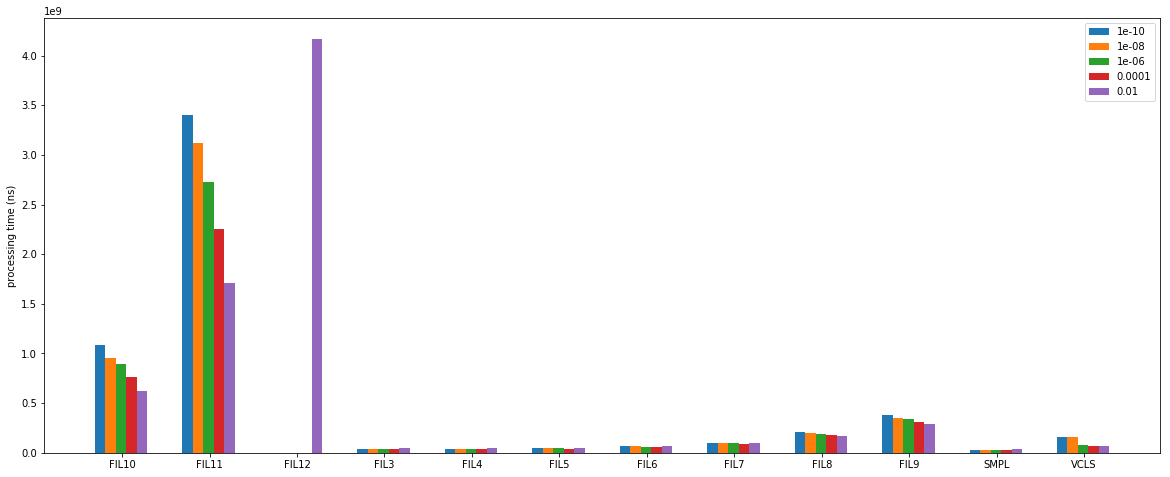

In [20]:
arrays=[]
for x in tols:
    arrays.append([])

tasks = sum_times_df.loc[:,time].reset_index()
tasks['index'] = np.arange(tasks.time.count())
for x in range(tasks.time.count()):
    nextTime = tasks.loc[tasks['index']==x].iloc[0].time
    arrays[x%len(tols)].append(nextTime)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

ind = np.arange(12)  # the x locations for the groups
xIdx = -0.25
wi = 0.12
i = 0
for array in arrays:
    ax.bar(height=array, x=ind+xIdx, width=wi, label=tols[i])
    xIdx = xIdx + wi
    i = i+1
    
ax.set_xticks(ind)
ax.set_xticklabels(models)
plt.legend()
plt.ylabel("processing time (ns)")
plt.show()

# Célfüggvény pontossága toleranciánként

In [87]:
def scatterPlotModel(MODEL, badTolerance, goodTolerance):
    filtered = df[df.model == MODEL].loc[:,[tolerance, point_id, result]]
    filtered_bad = filtered[filtered.tolerance == badTolerance].set_index(point_id)
    filtered_good = filtered[filtered.tolerance == goodTolerance].set_index(point_id)
    dataSize = min(len(filtered_bad.index), len(filtered_good.index))
    return (filtered_good.head(dataSize).result, filtered_bad.head(dataSize).result)

def getColorAndMarker(idx):
    c = "C" + str(idx % 10)
    m = ''
    if idx > 10:
        m = 'x'
    else:
        m = 'o'
    return (c, m)

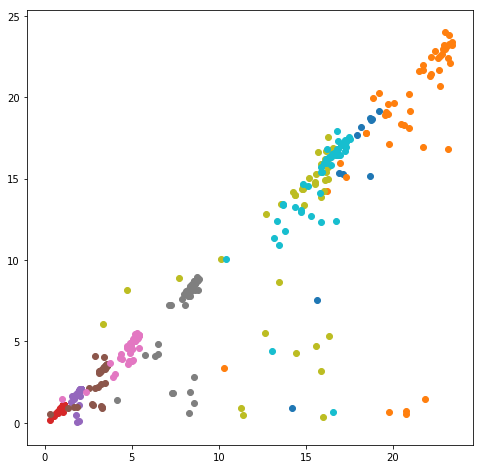

In [101]:
fig = plt.figure(figsize=(8,8))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# TODO utolsó két diagrammra nem marad szín...
for i in range(10):
    (x, y) = scatterPlotModel(models[i], 1e-2, 1e-8)
    plt.scatter(x=x, y=y, c=colors[i])
    i=i+1
    
plt.show()